## Imports and dataset

In [15]:
from src.models.optimized_bnn import BayesianNN, DBNN
from src.models.deep_ensemble import DeepEnsemble
from src.attacks.point_attacks_jax import attack

from src.utils import plot_ppds

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import numpyro
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from joblib import Parallel, delayed

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [17]:
import numpyro
numpyro.set_host_device_count(8)

In [18]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)

## MNIST - Reproducing Deep Ensemble results

In [19]:
# load MNIST data without tensorflow
from sklearn.datasets import fetch_openml

# Load MNIST from OpenML
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data.values, mnist.target.values
X = X / 255.0  # Normalize pixel values to [0, 1]
y = y.astype(int)
y = jax.nn.one_hot(y, 10)

# Split into training and testing datasets
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

In [20]:
# Fit the model
model = DeepEnsemble(input_dim=X_train.shape[1], hidden_units=200, output_dim=10, num_models=20, model_type='mnist_mlp')
path = '/Users/pgarc/projects/AdvReg/src/models/weights/DE/mnist'
try:
    model.load(path)
except FileNotFoundError:
    print('Not model found, fitting the model') 
    model.fit(
        X_train,
        y_train,
        300,
        batch_size=2048
    )
    model.save(path)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 92.14it/s]


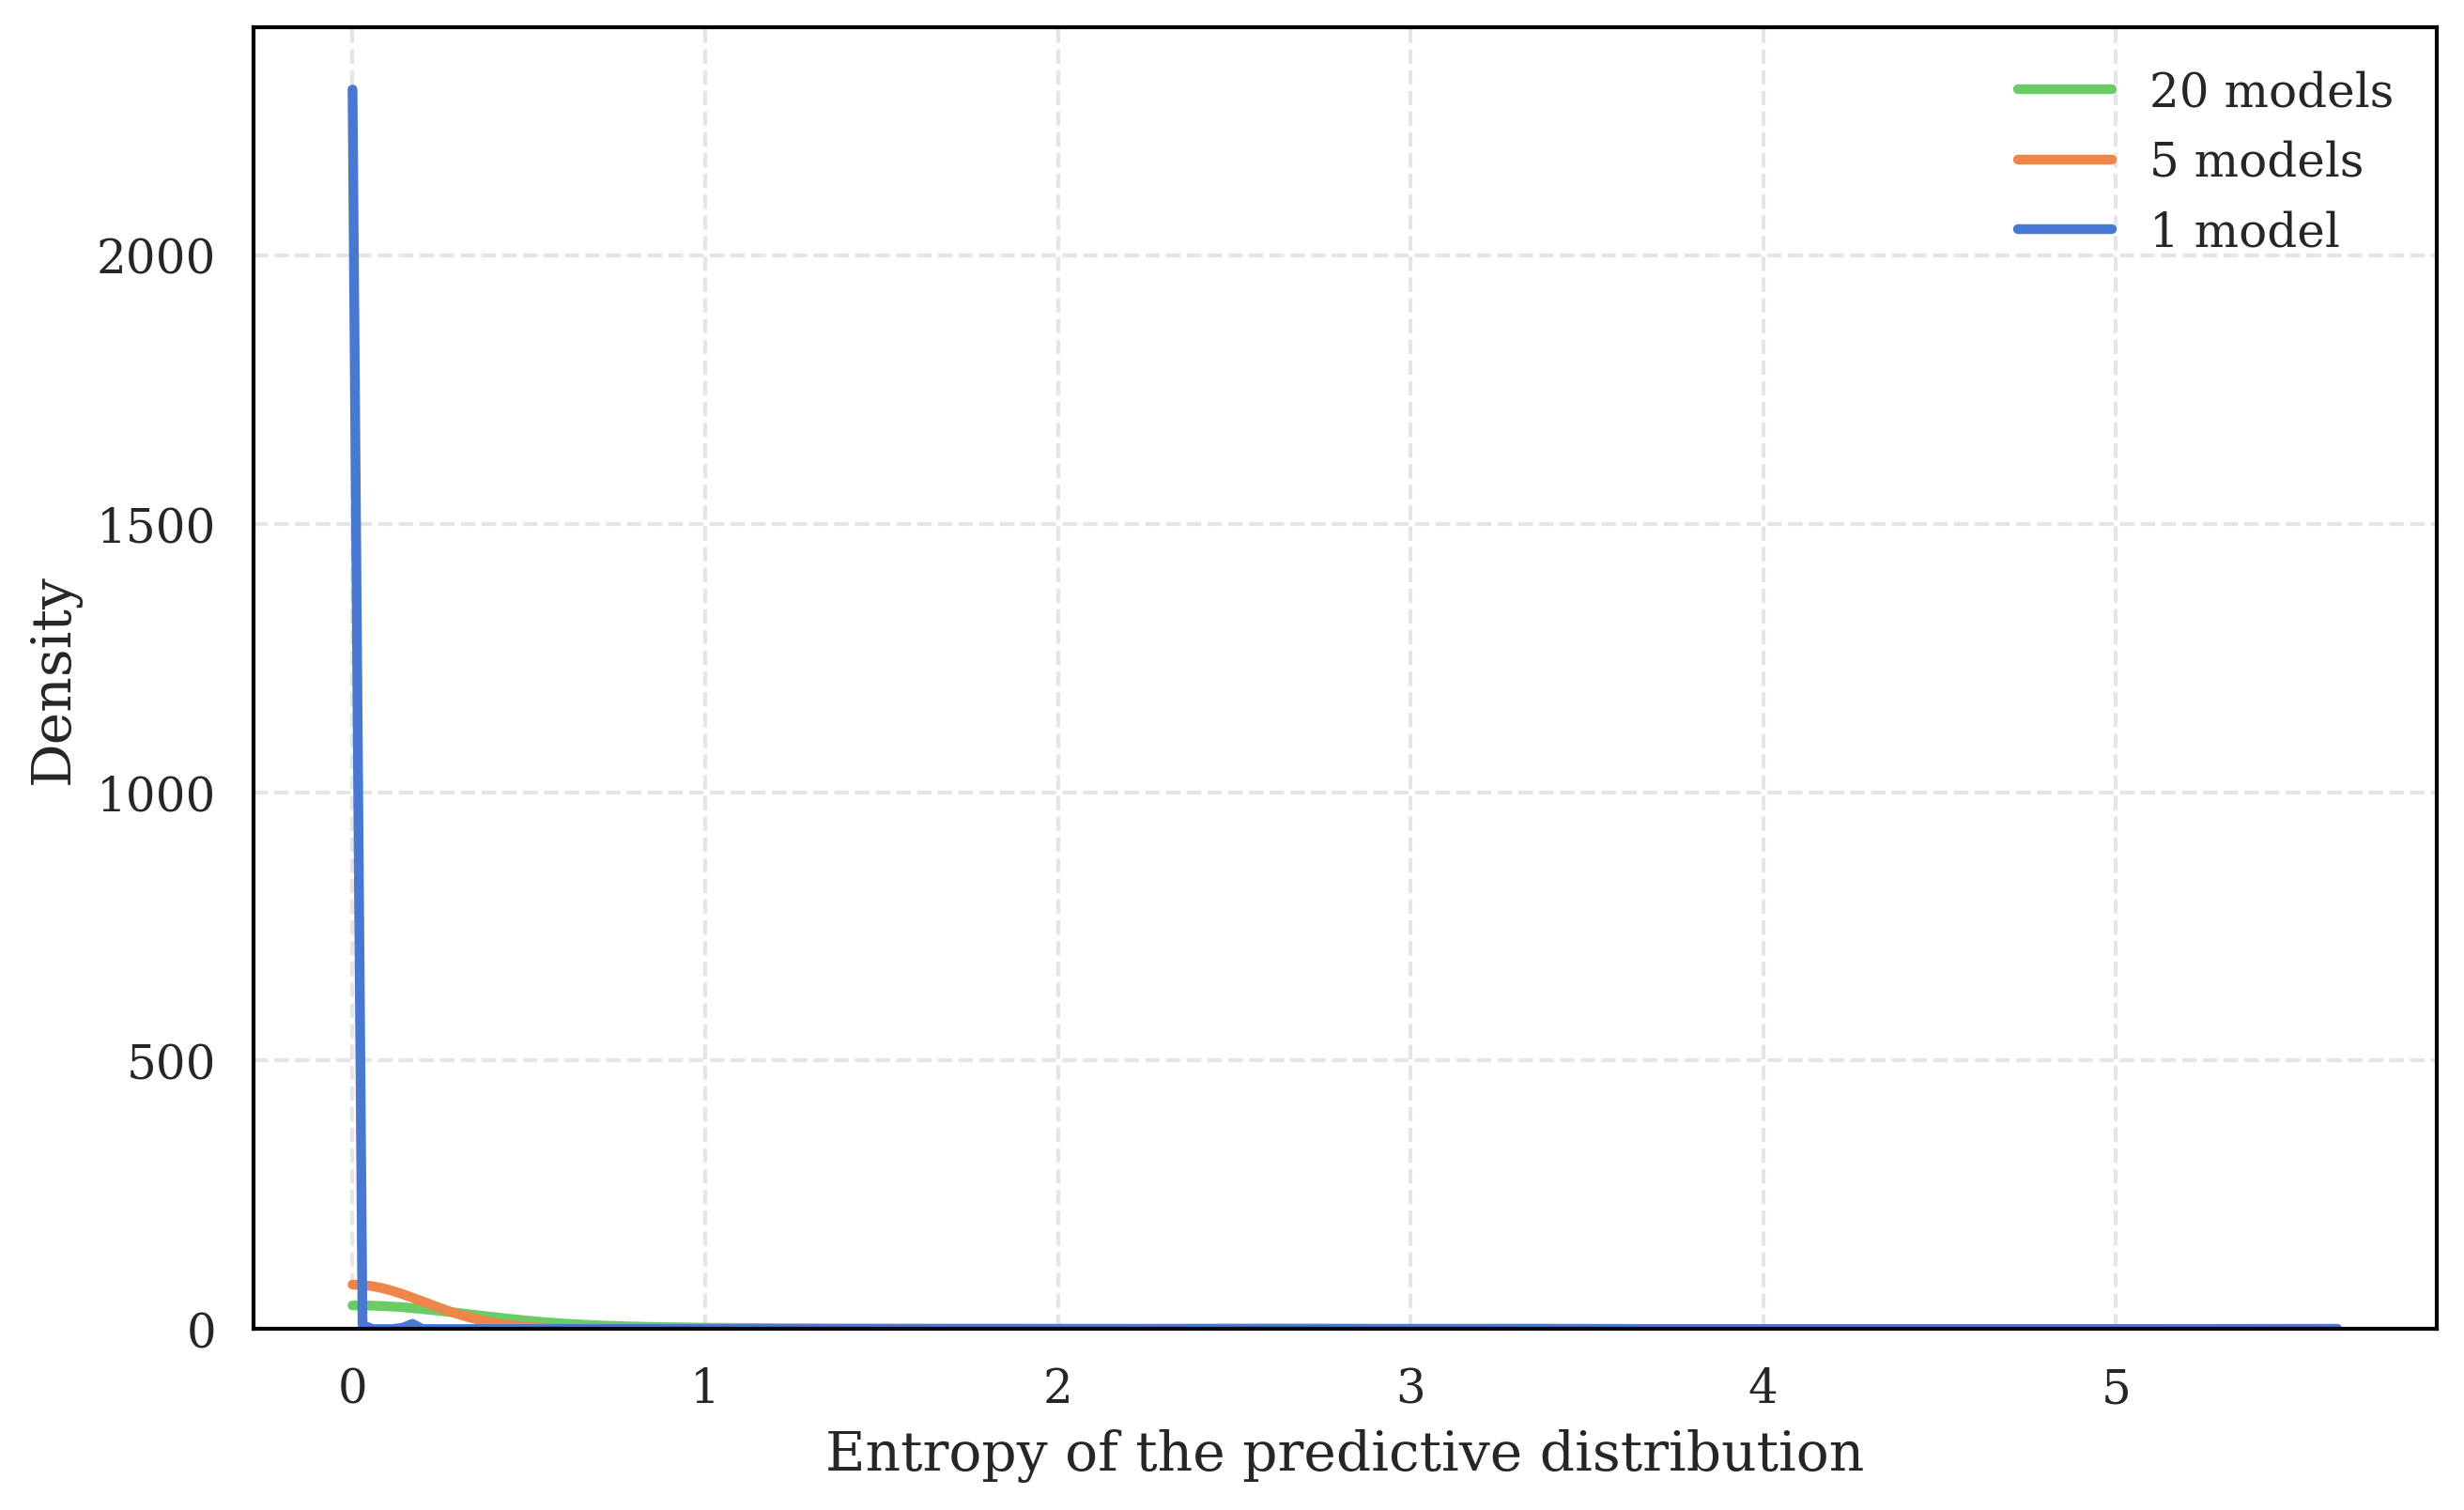

In [21]:
# Make histogram of the entropy of the predictive distribution when using 1, 5 and 20 models for the ensemble
all_entropies = []
path = '/Users/pgarc/projects/AdvReg/src/models/weights/DE/mnist'

for num_models in [1, 5, 20]:
    model = DeepEnsemble(input_dim=X_train.shape[1], hidden_units=200, output_dim=10, num_models=num_models, model_type='mnist_mlp')
    model.load(path)
    entropies = []
    for i in tqdm(range(100)):
        x = X_test[i]
        x = jax.numpy.array(x.reshape(1,-1))
        probs = model.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, num_models)
        entropies.append(- (probs * jax.numpy.log(probs) / jax.numpy.log(2)).sum())
    all_entropies.append(entropies)

plt.figure(figsize=(10, 6))
sns.histplot(np.array(all_entropies).T, kde=True, bins=10, color='black', alpha=0.)
plt.xlabel('Entropy of the predictive distribution')
plt.ylabel('Density')
plt.legend(['20 models', '5 models', '1 model'])
plt.show()

In [22]:
# Load notMNIST data without labels
import os
from PIL import Image
import numpy as np

# Ruta de la carpeta con imágenes
folder_path = '../data/notMNIST_small'

# Lista para almacenar las imágenes
images = []

for dirpath, dirnames, filenames in os.walk(folder_path):
    for filename in filenames:
        if filename.endswith('.png'):
            img_path = os.path.join(dirpath, filename)
            img = Image.open(img_path)
            img_gray = img.convert('L')
            img_array = np.array(img_gray)
            images.append(img_array)

X_notmnist = np.array(images).reshape(-1, 28*28) / 255.0

100%|██████████| 100/100 [00:01<00:00, 91.16it/s]


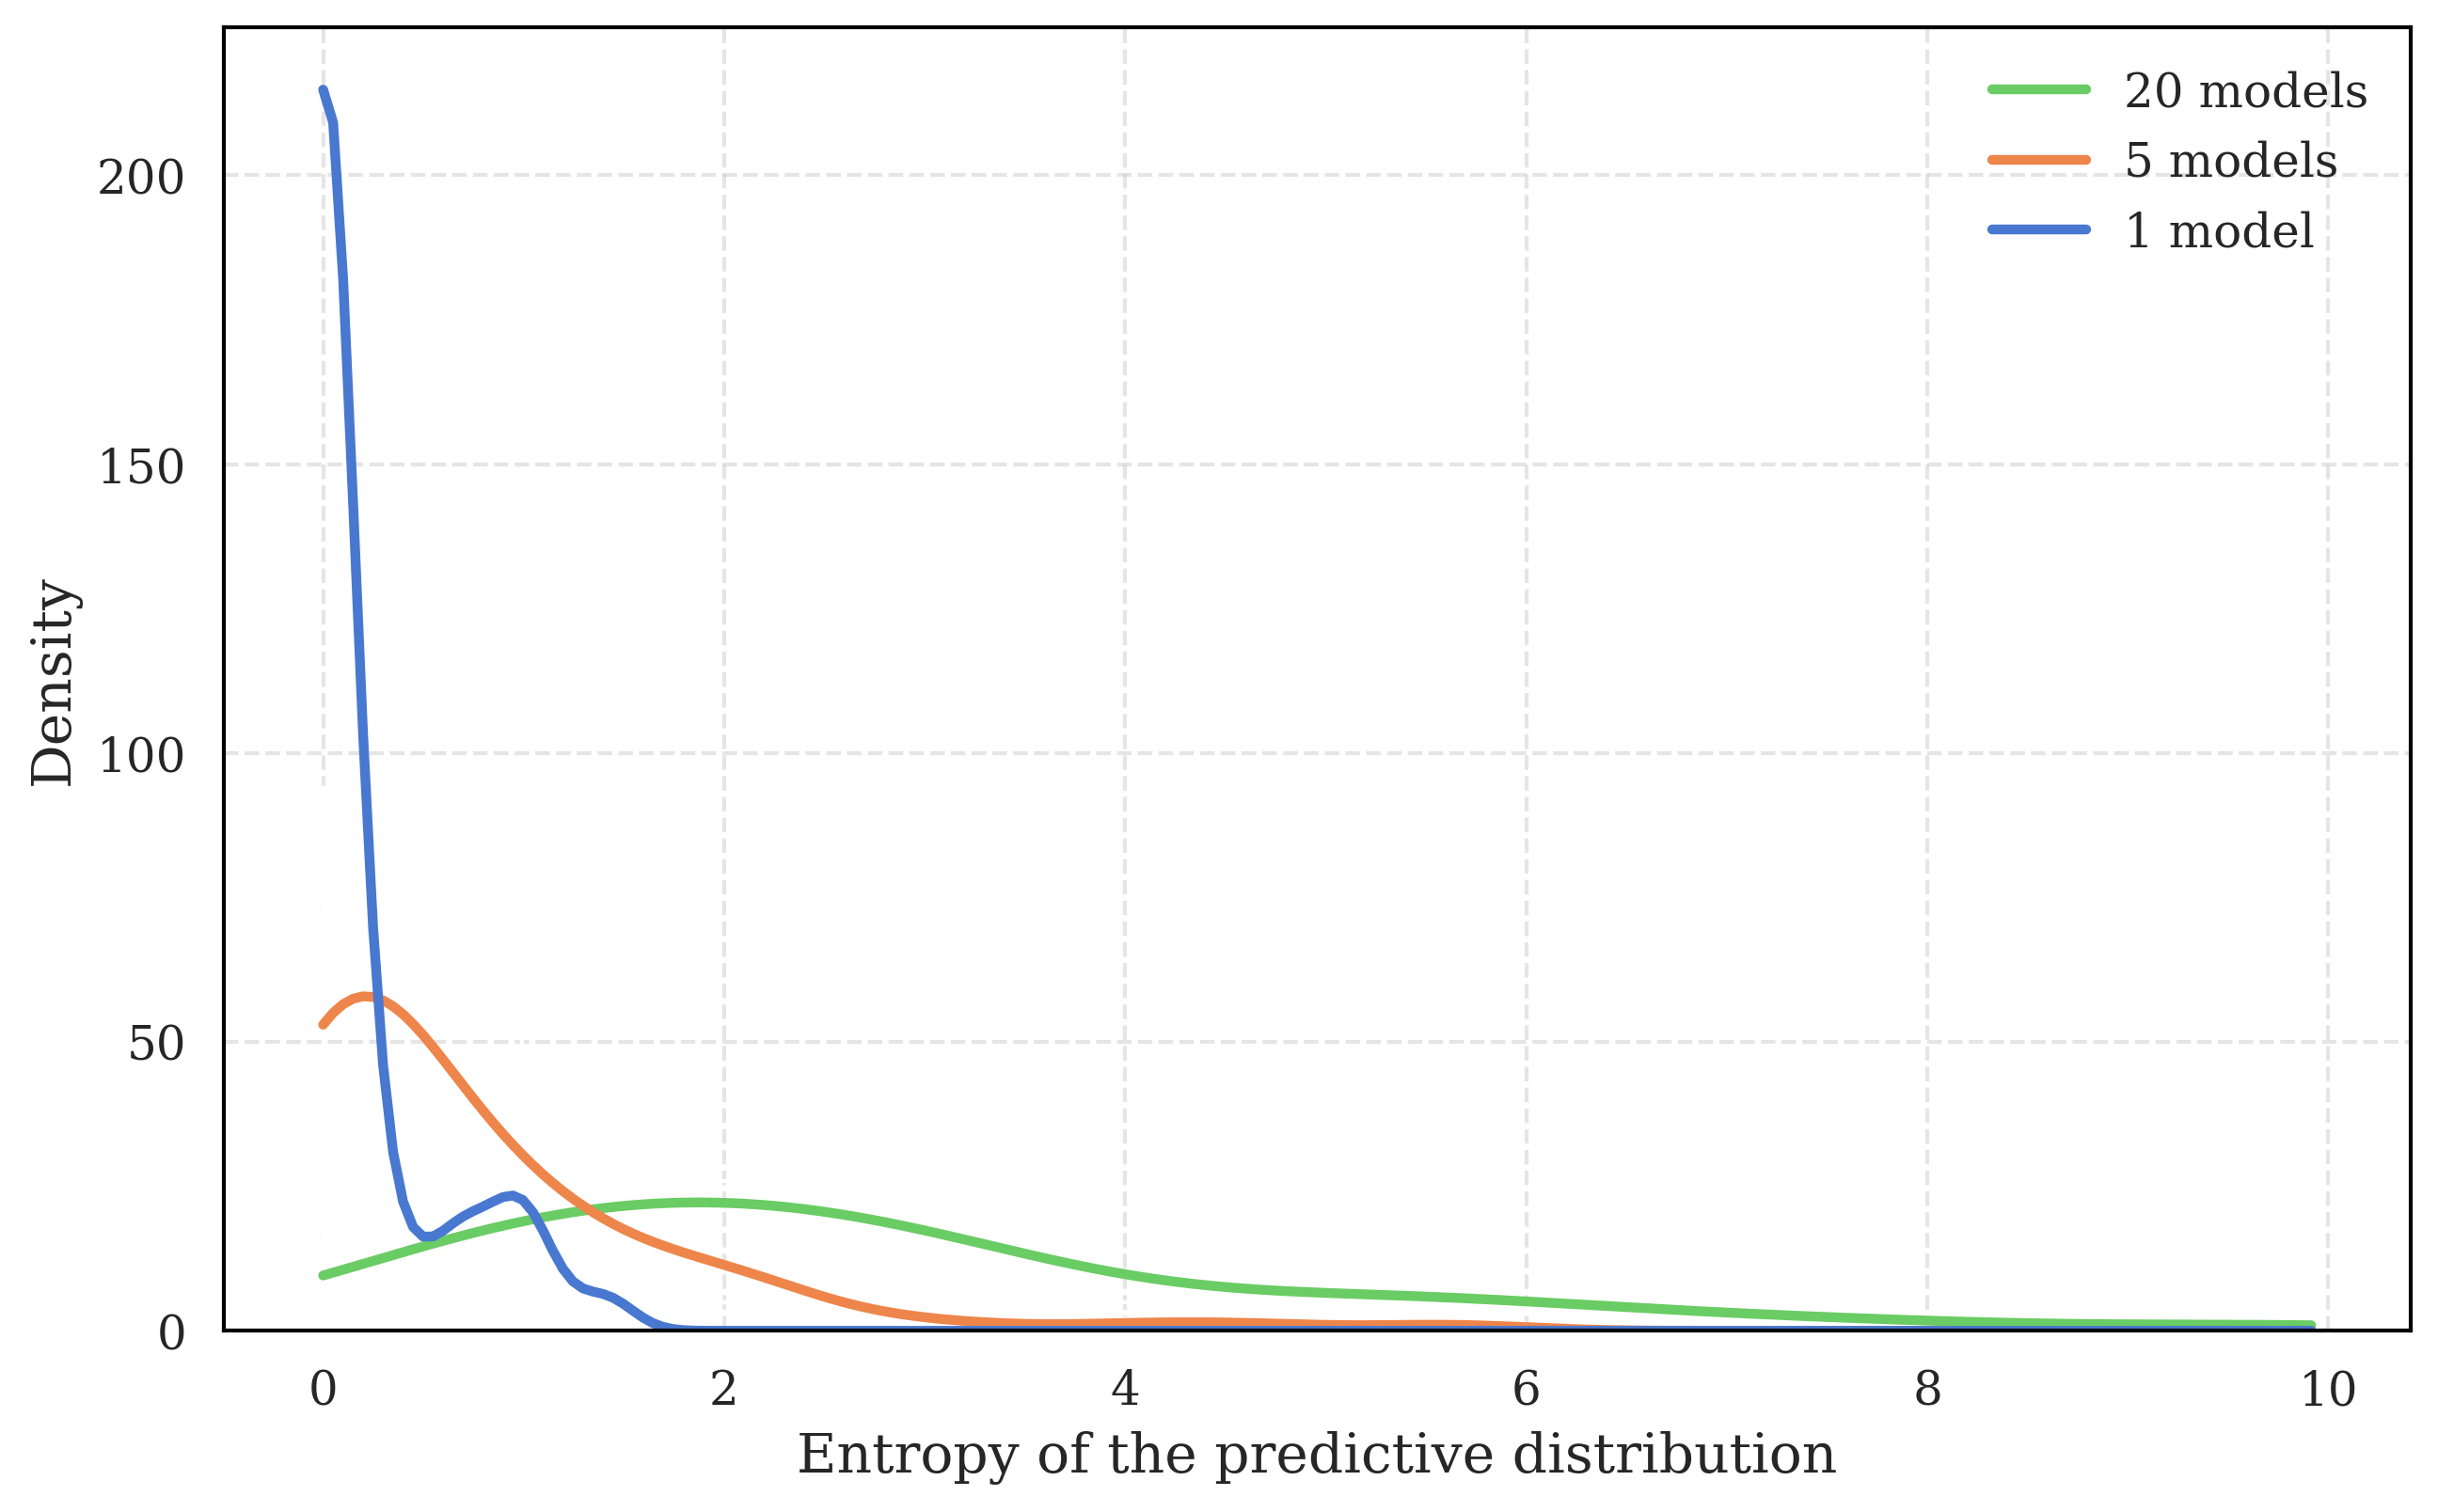

In [23]:
# Make histogram of the entropy of the predictive distribution when using 1, 5 and 20 models for the ensemble
all_entropies = []
path = '/Users/pgarc/projects/AdvReg/src/models/weights/DE/mnist'

rng = jax.random.PRNGKey(0)
for num_models in [1, 5, 20]:
    model = DeepEnsemble(input_dim=X_train.shape[1], hidden_units=200, output_dim=10, num_models=num_models, model_type='mnist_mlp')
    model.load(path)
    entropies = []
    for i in tqdm(range(100)):
        x = X_notmnist[i]
        x = jax.numpy.array(x.reshape(1,-1))
        rng, sample_rng = jax.random.split(rng)
        pred = model.sample_predictive_distribution_probs(sample_rng, x, num_models)
        entropies.append((jax.scipy.special.entr(pred) / jax.numpy.log(2)).sum())
    all_entropies.append(entropies)

plt.figure(figsize=(10, 6))
sns.histplot(np.array(all_entropies).T, kde=True, bins=10, color='black', alpha=0.)
plt.xlabel('Entropy of the predictive distribution')
plt.ylabel('Density')
plt.legend(['20 models', '5 models', '1 model'])
plt.show()

## Trying to break them

In [24]:
# Attack notMNIST data to lower the entropy of the predictive distribution
path = '/Users/pgarc/projects/AdvReg/src/models/weights/DE/mnist'
model = DeepEnsemble(input_dim=X_train.shape[1], hidden_units=200, output_dim=10, num_models=20, model_type='mnist_mlp')
model.load(path)

def entropy(x, pred):
    pred = pred.mean(axis=0)
    pred += 1e-8
    entr = - (pred * jnp.log(pred)).sum() / jnp.log(2)
    return entr

In [25]:
epsilons = [.2, .5, 1]
num_points = 40

100%|██████████| 40/40 [00:10<00:00,  3.80it/s]


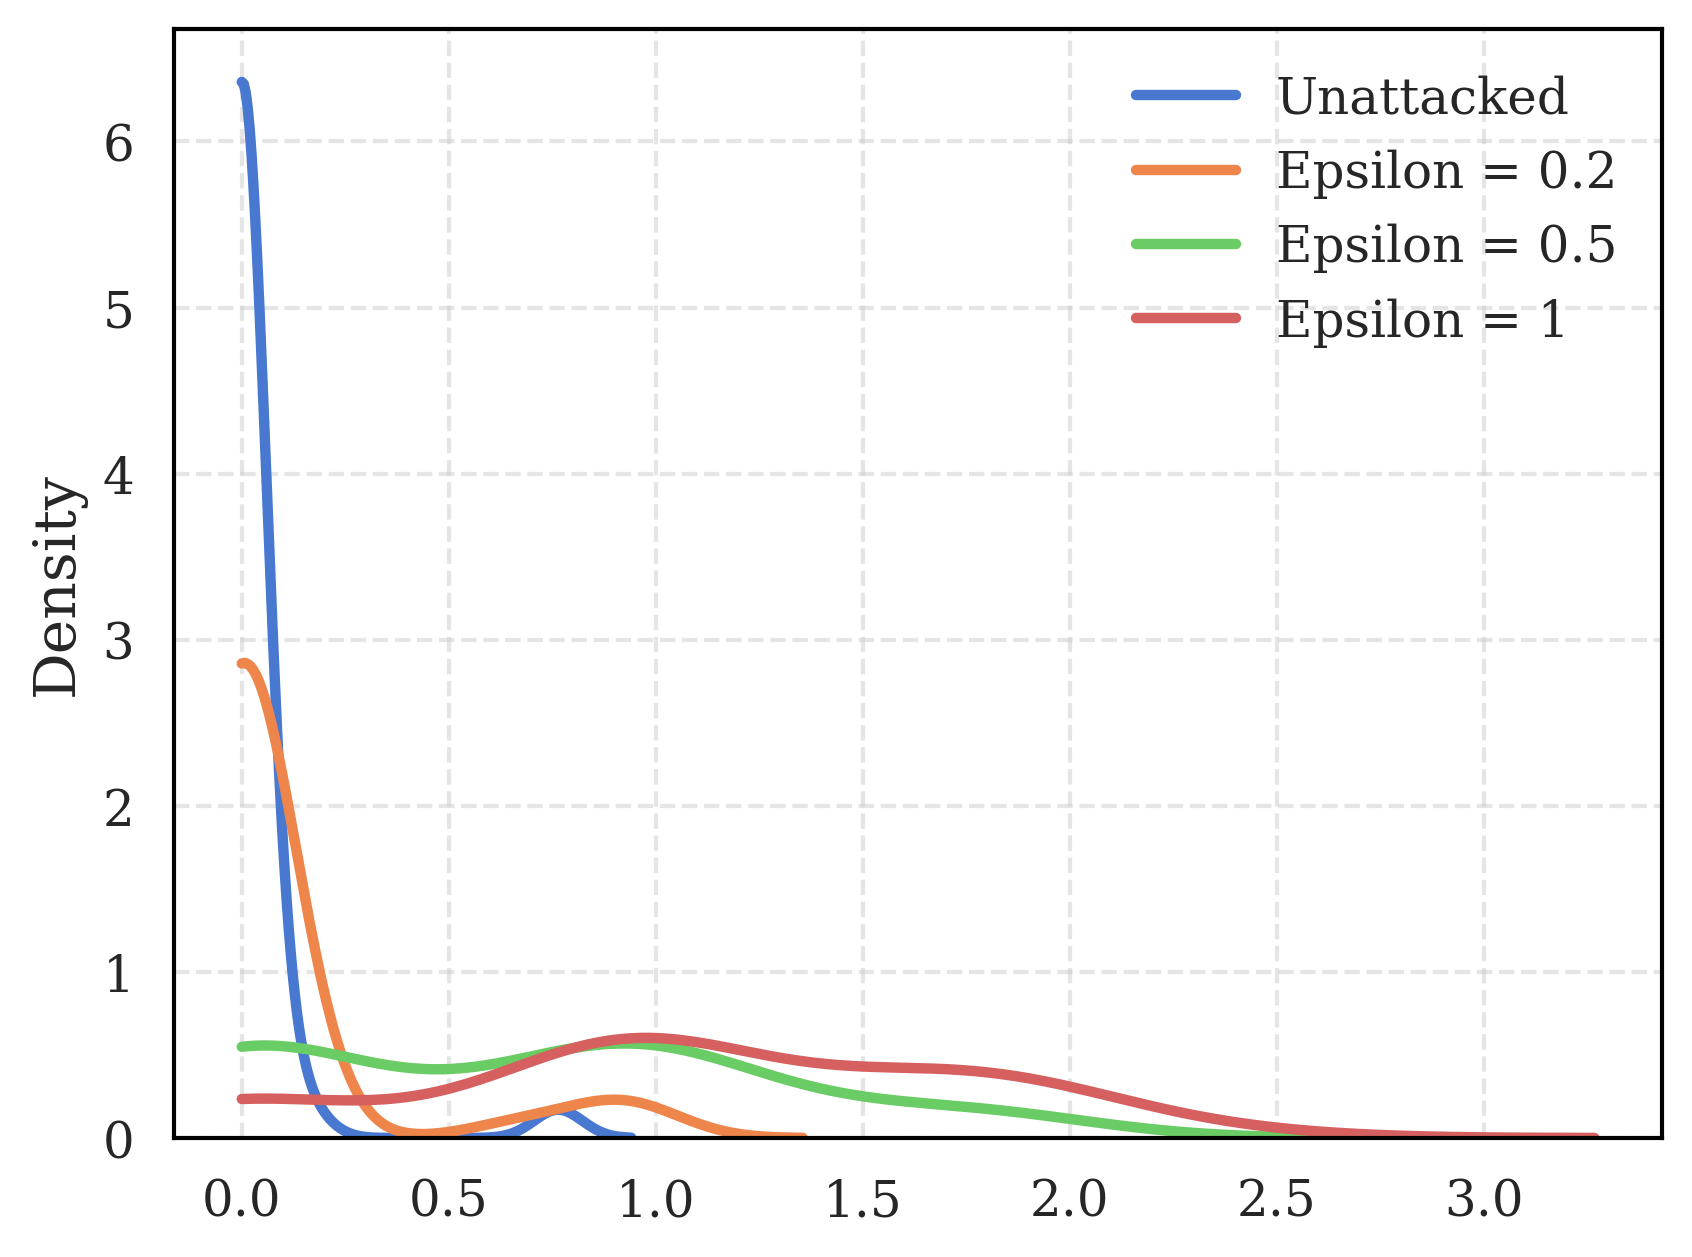

In [26]:
G = 20  # we want to rise the entropy of the predictive distribution

unattacked_entropies = []
rng = jax.random.PRNGKey(0)
for x in tqdm(X_test[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    rng, sample_rng = jax.random.split(rng)
    preds = model.sample_predictive_distribution_probs(sample_rng, x, 20)
    unattacked_entropies.append(entropy(x, preds))
sns.kdeplot(jnp.array(unattacked_entropies), clip=(0, 10))

def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    x_adv_values, loss_values, func_values = attack(x, model, G, func=entropy, samples_per_iteration=20, epsilon=eps, num_iterations=1000, learning_rate=1e-2)
    preds = model.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv_values[-1], 20)
    return entropy(x_adv_values[-1], preds)

for eps in epsilons:
    entropies = Parallel(n_jobs=8)(delayed(process)(x, eps) for x in tqdm(X_test[:num_points]))
    sns.kdeplot(jnp.array(entropies), clip=(0, 10))
    
legend = ['Unattacked'] + ['Epsilon = ' + str(eps) for eps in epsilons] 
plt.legend(legend)

  0%|          | 0/40 [00:00<?, ?it/s]/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
100%|██████████| 40/40 [00:12<00:00,  3.18it/s]


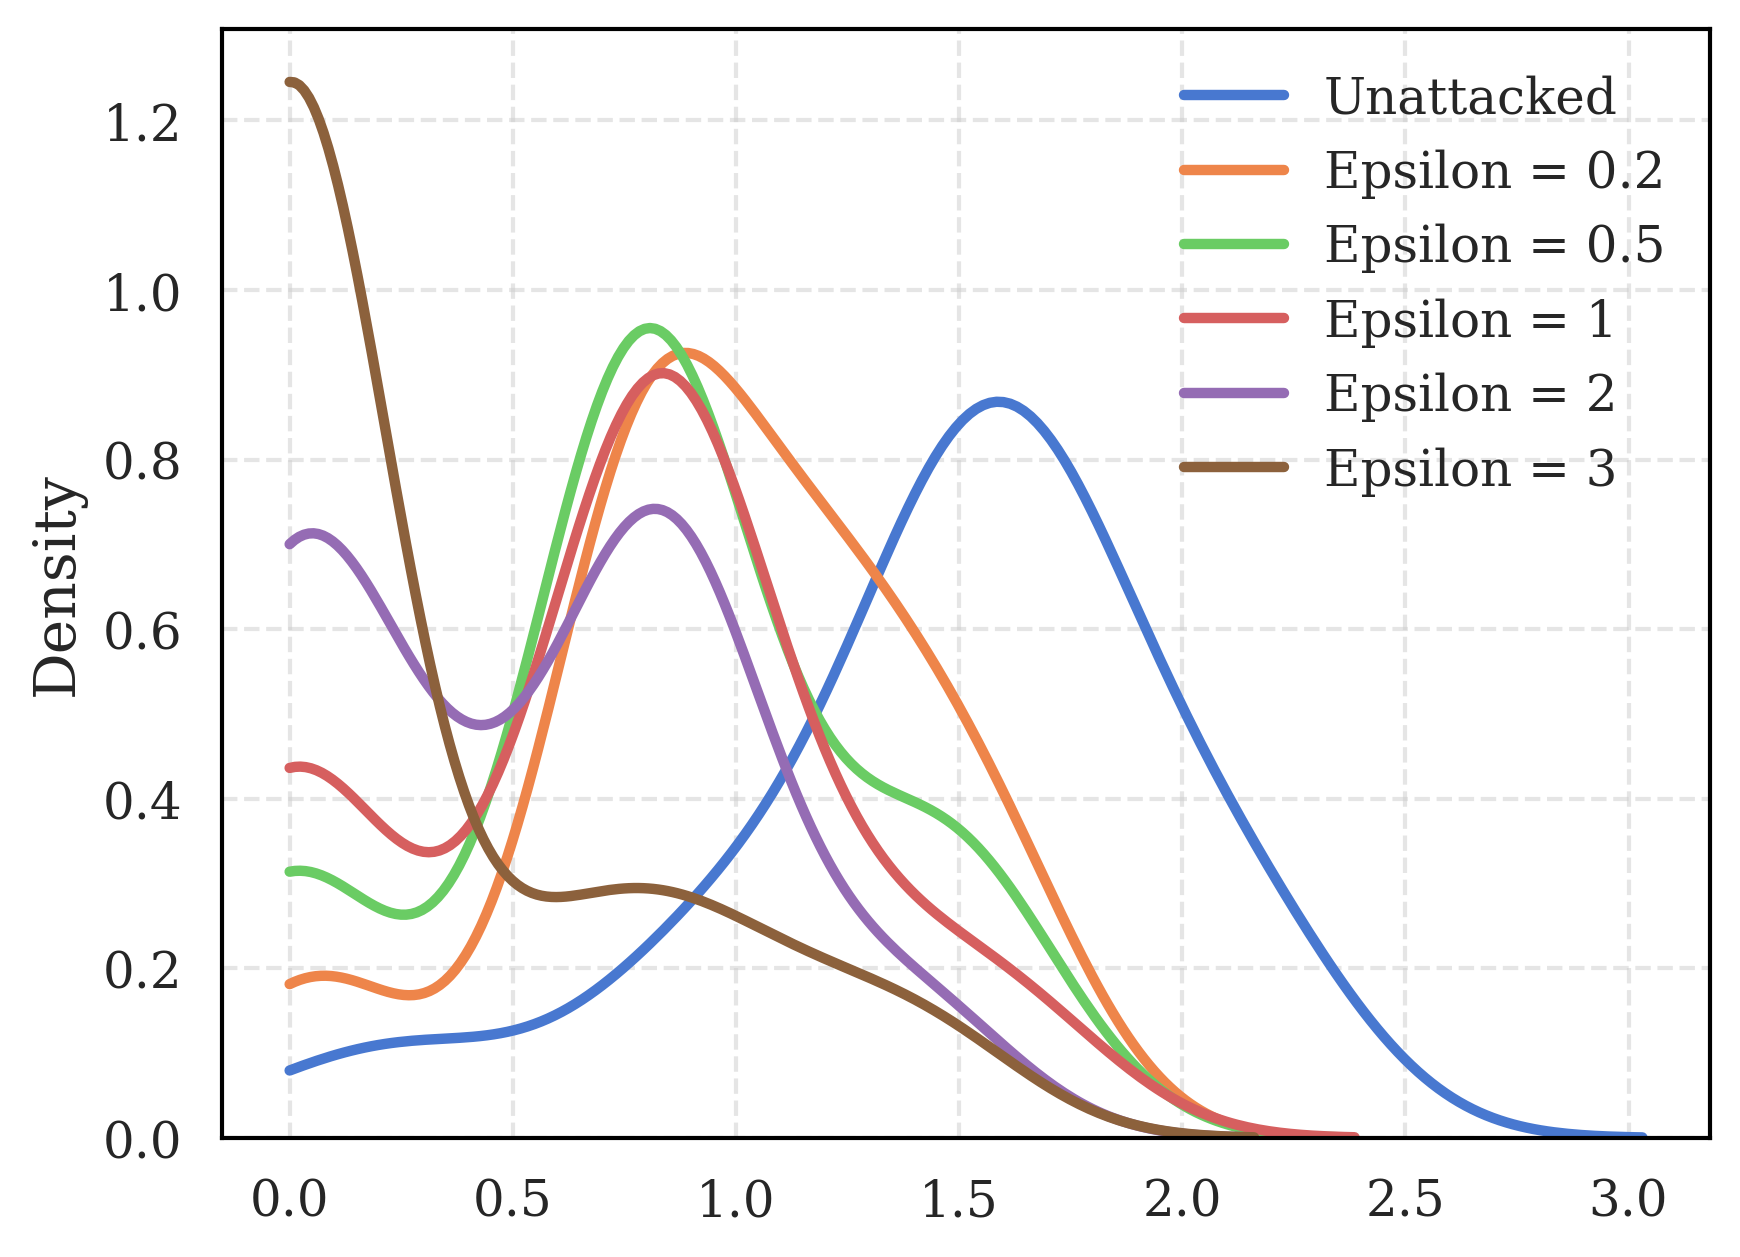

In [33]:
G = 0  # we want to lower the entropy of the predictive distribution

unattacked_entropies = []
rng = jax.random.PRNGKey(0)
for x in tqdm(X_notmnist[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    rng, sample_rng = jax.random.split(rng)
    preds = model.sample_predictive_distribution_probs(sample_rng, x, 20)
    unattacked_entropies.append(entropy(x, preds))
sns.kdeplot(jnp.array(unattacked_entropies), clip=(0, 10))

def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    x_adv_values, loss_values, func_values = attack(x, model, G, func=entropy, samples_per_iteration=20, epsilon=eps, num_iterations=1000, learning_rate=1e-2)
    preds = model.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv_values[-1], 20)
    return entropy(x_adv_values[-1], preds)

epsilons = [.2, .5, 1, 2, 3]
num_points = 40
for eps in epsilons:
    entropies = Parallel(n_jobs=8)(delayed(process)(x, eps) for x in tqdm(X_notmnist[:num_points]))
    sns.kdeplot(jnp.array(entropies), clip=(0, 10))

legend = ['Unattacked'] + ['Epsilon = ' + str(eps) for eps in epsilons] 
plt.legend(legend)